instalar osmnx y todas las 
```shell

    
    conda create --override-channels -c conda-forge -n OSMNX python=3 osmnx ```
    
ingresa a tu enviroment:
```shell
    source activate OSMNX```
    
instala jupyter:

```shell

    conda install jupyter```

In [34]:
import osmnx as ox, networkx as nx, geopandas as gpd, matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
ox.config(log_console=True, use_cache=True)

In [45]:

trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour
point=[19.43222,-99.13347]

In [48]:
G = ox.graph_from_point(point,distance=2000, network_type='drive')

In [47]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)


In [51]:

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute


In [39]:

iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
iso_colors

['#FCAB8E', '#FB7252', '#E73328', '#B31218', '#67000C']

In [40]:

isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

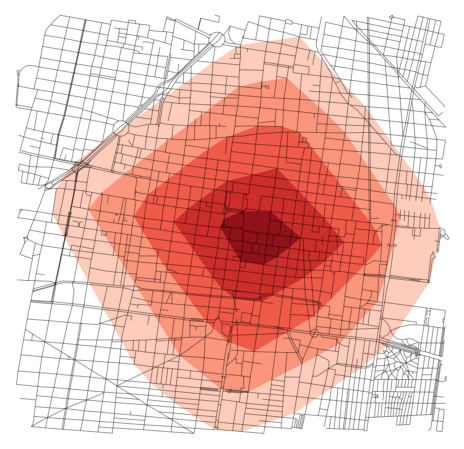

In [41]:

fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()